In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
from pycbc.filter import make_frequency_series
from calcwf import *
from interpolating_match import *

In [2]:
comb_harm_consistent([10, 2, 1], [0, np.pi/3, -np.pi/3], harms=[0,1,-1], return_denom=False)

0.22360679774997896

In [3]:
with open(os.path.join('grid_data', 'dataslot_29', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
grid_data = find_min_max(grid_data, extra_keys=['h1_h0', 'h-1_h0', 'h2_h0', 'h1_h-1_h0', 'h1_h-1_h2_h0', 'h1_h-1_h0_pca', 'h1_h-1_h0_pcn', 'h1_h-1_h2_h0_pcn'])

/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:139: RuntimeWarning: invalid value encountered in sqrt
  num = np.sqrt(data[chirp]['h1']**2+np.cos(angle)*data[chirp]['h-1']**2)


In [4]:
grid_data.keys()

dict_keys([5.109216918045607, 8.311202280819249, 11.737898138164017, 15.342013196939702, 19.09412877604935, 22.973967099940698, 26.96660856486353, 31.060565479858784, 35.24669064333487, 39.51750973664827, 43.86678863029888, 48.28923991500753, 52.780316430915754, 57.33606154625207])

Text(0, 0.5, 'rho_x/rho_0')

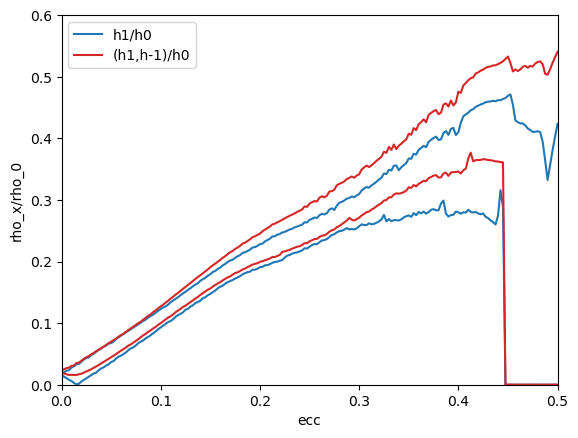

In [16]:
chirp = 48.28923991500753
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h0_max'], c='C0', label='h1/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h0_min'], c='C0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h-1_h0_max'], c='C1', label='h-1/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h-1_h0_min'], c='C1')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h2_h0_max'], c='C2', label='h2/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h2_h0_min'], c='C2')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_max'], c='C3', label='(h1,h-1)/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_min'], c='C3')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pca_max'], c='C4', label='(h1,h-1)pca/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pca_min'], c='C4')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pcn_max'], c='C5', label='(h1,h-1)pcn/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pcn_min'], c='C5')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h2_h0_pcn_max'], c='C6', label='(h1,h-1,h2)pcn/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h2_h0_pcn_min'], c='C6')
plt.legend()
plt.xlim(0, np.min([0.5, grid_data[chirp]['fid_e']*4]))
plt.ylim(0, 0.6)
plt.xlabel('ecc')
plt.ylabel('rho_x/rho_0')

# Phase consistency

We expect that the difference between the phase of the match with h1 and h0 should be the same as the difference between the phase of the match with h0 and h-1, as they both give estimates of the initial mean anomaly. We can test this here by looking at the discrepancy for every point in the grid.

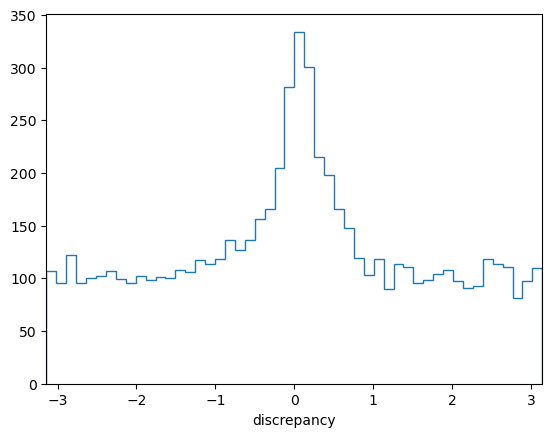

(0.0, 0.26666666666666666)

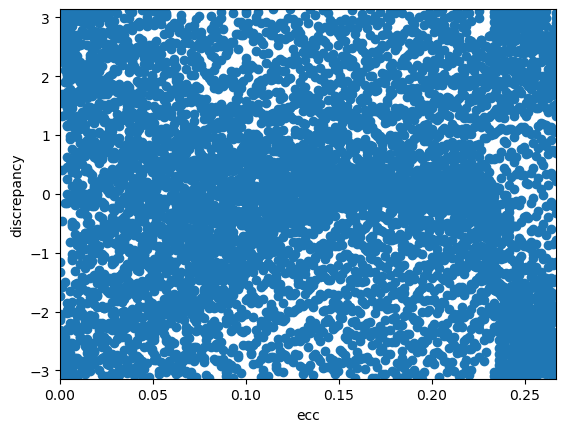

In [11]:
chirp = 11.737898138164017

# Calculating phase differences
h0_phase = grid_data[chirp]['h0_phase']
h1_phase = grid_data[chirp]['h1_phase']
hn1_phase = grid_data[chirp]['h-1_phase']
diff_0 = h1_phase - h0_phase
diff_1 = h0_phase - hn1_phase

# Calculating discrepancies and restricting to between -pi and pi
consistency = diff_1 - diff_0
consistency = (consistency+np.pi)%(2*np.pi)-np.pi

# Plot histogram
plt.hist(consistency.flatten(), bins=50, histtype='step')
plt.xlabel('discrepancy')
plt.xlim(-np.pi, np.pi)
plt.show()

# Plot scatter plot as function of eccentricity along degeneracy line
for i, cons in enumerate(consistency):
    plt.scatter(np.full(len(cons), grid_data[chirp]['e_vals'][i]), cons, c='C0')
plt.ylabel('discrepancy')
plt.xlabel('ecc')
plt.ylim(-np.pi, np.pi)
plt.xlim(0, grid_data[chirp]['e_vals'][-1])

We can see that the discrepancy distribution is indeed centred around zero, supporting our theory that these phase differences should be the same. The discrepancies tend to get bigger at very low eccentricities, likely due to the non/minimal detection of higher harmonics, as well as at high eccentricities, likely due to the similarities to harmonics built at the fiducial eccentricity degrading.

## Equation derivation

We want to maximise the likelihood given by

$$
\log{\Lambda} = (s|h) - \frac{1}{2} (h|h),
$$

where we are using the convention here that (a|b) is the real part of the inner product.

$h$ is the trial waveform given by

$$
h = \sum_k A_k e^{i\phi_k} h_k,
$$

and $s$ is the data given by

$$
s = h^\prime + n,
$$

where $h^\prime$ is the true signal in the data, and $n$ is the noise.

Assuming the noise to be stationary and Gaussian, $(n|h) = 0$ and so we can rewrite the likelihood as 

$$
\log{\Lambda}= (h^\prime|h) - \frac{1}{2} (h|h).
$$

We can now use the orthonormality of $h_k$, where $(h_j|h_k) = \delta_{jk}$ to write this as

$$
\log{\Lambda}= \sum_k A_k^\prime A_k \cos(\phi_k - \phi_k^\prime) - \frac{1}{2} A_k^2.
$$

We will now enforce phase consistency by parameterising $\phi_k$ as 

$$
\phi_k = \alpha + k\beta
$$

in order to find

$$
\log{\Lambda}= \sum_k A_k^\prime A_k \cos(\alpha + k\beta - \phi_k^\prime) - \frac{1}{2} A_k^2.
$$

We can maximise over this numerically using initial guesses of $A_k = A_k^\prime$, $\alpha = \phi_0^\prime$, and $\beta = \phi_1^\prime - \phi_0^\prime$.

The fraction we are then looking for is

$$
\frac{\sqrt{\sum_kA_k^2}}{A_0}.
$$

We can now perform partial differentiation with respect to $A_k$, $\alpha$, and $\beta$ to find a set of simultaneous equations which describe the stationary points of this function.

$$
\frac{\partial \log{\Lambda}}{\partial A_k} = A_k^\prime \cos(\alpha + k\beta - \phi_k^\prime) - A_k = 0.
$$

$$
A_k = A_k^\prime \cos(\alpha + k\beta - \phi_k^\prime).
$$

$$
\frac{\partial \log{\Lambda}}{\partial \alpha} = - \sum_k A_k^\prime A_k \sin(\alpha + k\beta - \phi_k^\prime) = 0.
$$

$$
\frac{\partial \log{\Lambda}}{\partial \beta} = - \sum_k k A_k^\prime A_k \sin(\alpha + k\beta - \phi_k^\prime) = 0.
$$

We can substitute the equation for $A_k$ into the others to get

$$
\sum_k {A_k^\prime}^2 \sin(2\alpha + 2k\beta - 2\phi_k^\prime) = 0,
$$

$$
\sum_k k {A_k^\prime}^2 \sin(2\alpha + 2k\beta - 2\phi_k^\prime) = 0.
$$

We want to find the overall SNR of the harmonics while enforcing phase consistency between them. This comes down to calculating the following

$$
\mathrm{SNR}^2 = (h|s),
$$

where $s$ is the data, and $h$ is the overall waveform given by

$$
h = \sum_k A_k h_k = A_0 h_0 + A_1 h_1 + A_{-1} h_{-1},
$$

and $A_k$ are complex coefficients represented by 

$$
A_k = \rho_k e^{-i\phi_k}.
$$

As the amplitude coefficients of the harmonics are equal to their SNR here, $(h_k|h_k) = 1$ for all $k$ by definition.

We are not (currently) enforcing any conditions on the magnitudes of the harmonic SNRs, and so can set all $\rho_k$ in this model equal to the measured harmonic SNR magnitudes $\rho_k^\prime$. We will not however in general have $\phi_k = \phi_k^\prime$ as we are enforcing a condition on the SNR phases parameterised by the angles $\alpha$ and $\beta$:

$$
\phi_k = \alpha + k \beta.
$$

We can therefore expand $h$ out as 

$$
(h|s) = \sum_k A_k (h_k|s) = \sum_k \rho_k e^{-i\phi_k} (h_k|s).
$$

(h_k|s) is now simply the measured SNR of each harmonic, and so we can write this as

$$
(h|s) = \sum_k \rho_k e^{-i\phi_k} \rho_k e^{i\phi^\prime_k} = \sum_k \rho_k^2 e^{i(\phi_k^\prime-\phi_k)}.
$$

We can then take the real part to find the square of the SNR as 

$$
\sum_k \rho_k^2 \cos(\phi_k^\prime-\phi_k).
$$

We now must simply maximise this quantity numerically over $\alpha$ and $\beta$, starting with an initial guess of $\alpha = \phi_0^\prime$ and $\beta = \phi_1^\prime - \phi_0^\prime$.

Once we have found these values of $\alpha$ and $\beta$ we can simply plug them into the following equation.

$$
\sqrt{\frac{\rho_1^2 \cos(\phi_1^\prime-\phi_1) + \rho_{-1}^2 \cos(\phi_{-1}^\prime-\phi_{-1})}{\rho_0^2 \cos(\phi_0^\prime-\phi_0)}}.
$$